http://localhost:8080/notebooks/git/shopee-product-matching/working/dev0014--threshold--3feats.ipynb

# setup

In [9]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

HOME = '/data/git/shopee-product-matching'
pdata = f'{HOME}/input/shopee-product-matching'

# metric

In [2]:
# def getMetric(col):
#     def f1score(row):
#         n = len( np.intersect1d(row.target,row[col]) )
#         return 2*n / (len(row.target)+len(row[col]))
#     return f1score

def getf1(x,y):
    n = len(np.intersect1d(x,y))
    return 2*n / (len(x)+len(y))

def getf1s(xs,ys):
    return (getf1(x,y) for x,y in zip(xs,ys))

def meanf1(xs,ys):
    return np.mean(list(getf1s(xs, ys)))

# data and target

In [3]:
df = pd.read_csv(f'{pdata}/train.csv')

pids = df.posting_id.values

display(df.head(2))

grp2ids = df.groupby('label_group').posting_id.agg('unique').to_dict()
targets = df.label_group.map(grp2ids)

targets[:2]

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045


0     [train_129225211, train_2278313361]
1    [train_3386243561, train_3423213080]
Name: label_group, dtype: object

# baselines

## self baseline

In [4]:
preds = df.posting_id.apply(lambda x: [x])
print(preds[0], targets[0])

meanf1(preds,targets)

['train_129225211'] ['train_129225211' 'train_2278313361']


0.4608481791365001

## same hash baseline

In [5]:
hsh2ids = df.groupby('image_phash').posting_id.agg('unique').to_dict()
preds = df.image_phash.map(hsh2ids)
print(preds[0], targets[0])

meanf1(preds,targets)

['train_129225211'] ['train_129225211' 'train_2278313361']


0.5530933399168149

## image sims

In [6]:
feats = np.load(f"{HOME}/output/dev0005/vfeats.npy")
feats.shape, feats.min(), feats.max()

((34250, 1280), -0.26786401867866516, 6.02245569229126)

In [7]:
feats[:3,:10]

array([[-0.15162036, -0.20200732, -0.07988038, -0.01763012, -0.03462825,
         0.08004601,  0.22869602, -0.11427961,  0.00247513, -0.10201114],
       [ 0.08407991, -0.1057606 , -0.10895672,  0.28222248, -0.1978499 ,
        -0.0591195 , -0.14243783, -0.08416796,  0.04849764, -0.22471595],
       [-0.10569465, -0.15444288,  0.21543284,  0.08538498,  0.25567672,
        -0.12253671,  1.20475686, -0.01302597, -0.04933466,  0.46700051]])

In [74]:
nbrs = NearestNeighbors(n_neighbors=50, algorithm='auto').fit(feats)
dists, idx = nbrs.kneighbors(feats)

In [75]:
dists.shape

(34250, 50)

In [76]:
idx

array([[    0,   686,  9813, ..., 12609, 12610, 12607],
       [    1,   469,   194, ...,  3427, 26046, 24122],
       [    2,  3446,  7973, ..., 27670, 21360, 23891],
       ...,
       [34247, 23056, 18379, ...,  1891, 11575, 30428],
       [34248, 13887, 20813, ...,  3677, 33978,  3327],
       [34249, 33792, 18226, ..., 20342,  8398, 20229]])

In [78]:
dists.mean(), dists.max()

(10.880367559467002, 18.636531245308294)

In [38]:
preds_idx = [o[:2] for o in idx]
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

0.5734897998861994

In [83]:
thrsh = 6.
isclose = dists<=thrsh
preds_idx = (np.where(x)[0] for x in isclose)
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

6.228710462287104e-05

In [66]:
def get_preds_by_thrsh(dists, thrsh):
    isclose = dists<=thrsh
    preds_idx = (np.where(x)[0] for x in isclose)
    return [pids[o] for o in preds_idx]

preds = get_preds_by_thrsh(dists, thrsh=10)
meanf1(preds,targets)

0.00010063042248529582

In [67]:
thrshes = np.linspace(0,20,num=21)
thrshes

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [68]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, thrsh)
    f1_lst.append(meanf1(preds,targets))
    

100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


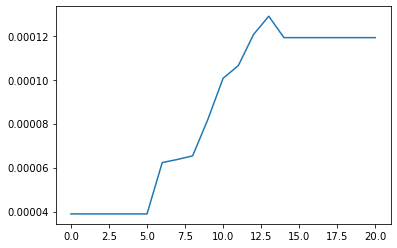

In [70]:
plt.plot(thrshes, f1_lst)